# How to Directly Access MERRA-2 Data from an S3 Bucket with Python
### Author: Chris Battisto
### Date Authored: 1-11-22

### Timing

Exercise: 30 minutes

<p></p>

<div style="background:#fc9090;border:1px solid #cccccc;padding:5px 10px;"><big><b>Note:  </b>Because this notebook uses the S3 protocol, <em><strong>it will only run in an environment with <a href="https://disc.gsfc.nasa.gov/information/glossary?keywords=%22earthdata%20cloud%22&amp;title=AWS%20region">us-west-2 AWS access</a></strong></em>.</big></div>

### Overview

This notebook demonstrates how to access and plot a Modern-Era Retrospective analysis for Research and Applications (MERRA-2) M2T1NXSLV.5.12.4 file hosted via an Amazon S3 bucket. It demonstrates how to access an S3 bucket with the S3FS library and then plot sea-level pressure contours of a single file with Cartopy and Matplotlib. 

### Prerequisites

This notebook was written using Python 3.8, and requires these libraries and files: 
- xarray
- cartopy
- matplotlib
- S3FS
  - S3FS documentation: https://s3fs.readthedocs.io/en/latest/install.html\
- Boto3
  - Boto3 documentation: https://boto3.amazonaws.com/v1/documentation/api/latest/index.html
- netrc file with valid Earthdata Login credentials.
- Approval to access the GES DISC archives with your Earthdata credentials (https://disc.gsfc.nasa.gov/earthdata-login)


### Import Libraries

In [1]:
from netrc import netrc
from subprocess import Popen
from platform import system
from getpass import getpass
import os
import requests
import xarray as xr
import s3fs
import boto3
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import warnings
from IPython.display import display, Markdown

warnings.filterwarnings('ignore')
%matplotlib inline

### Check AWS Region before running notebook

A common error when executing this notebook occurs when the notebook is run outside of the us-west-2 AWS region. Here, we check the region using the Boto3 Python library, and throw a ValueError if you are outside the region.

This cell is not necessary to access the S3 buckets for users inside the us-west-2 region, and can be commented out or deleted at the users' discretion.

In [2]:
if (boto3.client('s3').meta.region_name == 'us-west-2'):
    display(Markdown('### us-west-2 Region Check: &#x2705;'))
else:
    display(Markdown('### us-west-2 Region Check: &#10060;'))
    raise ValueError('Your notebook is not running inside the AWS us-west-2 region, and will not be able to directly access NASA Earthdata S3 buckets')
    

### us-west-2 Region Check: &#x2705;

### Generate .netrc file with your Earthdata Credentials

Alternatively, you can upload a previously generated .netrc file to <code>~/root</code> using the file explorer panel.
If you believe you have entered an incorrect username or password, you can open up a terminal instance by clicking the blue "plus" button in the top left corner, selecting "Terminal", and then remove the previously generated netrc by typing in <code>rm .netrc</code>. Then, this cell can be rerun to generate a new netrc file.

In [3]:
urs = 'urs.earthdata.nasa.gov'    # Earthdata URL endpoint for authentication
prompts = ['Enter NASA Earthdata Login Username: ',
           'Enter NASA Earthdata Login Password: ']

netrc_name = ".netrc"

# Determine if netrc file exists, and if so, if it includes NASA Earthdata Login Credentials
try:
    netrcDir = os.path.expanduser(f"~/{netrc_name}")
    # Check credentials against URS, and if username exists
    netrc(netrcDir).authenticators(urs)[0]

# Below, create a netrc file and prompt user for NASA Earthdata Login Username and Password
except FileNotFoundError:
    homeDir = os.path.expanduser("~")
    Popen('touch {0}{2} | echo machine {1} >> {0}{2}'.format(homeDir + os.sep, urs, netrc_name), shell=True)
    Popen('echo login {} >> {}{}'.format(getpass(prompt=prompts[0]), homeDir + os.sep, netrc_name), shell=True)
    Popen('echo \'password {} \'>> {}{}'.format(getpass(prompt=prompts[1]), homeDir + os.sep, netrc_name), shell=True)
    # Set restrictive permissions
    Popen('chmod 0600 {0}{1}'.format(homeDir + os.sep, netrc_name), shell=True)

### Get S3 Token

Retrieve your S3 access token and define an S3 direct access file system handler with S3FS. This token expires after one hour, and this block will need to be rerun if time expires. If you receive an error, double-check that your username and password were entered correctly in your netrc file, or that you can access the following URL: https://data.gesdisc.earthdata.nasa.gov

In [4]:
gesdisc_s3 = "https://data.gesdisc.earthdata.nasa.gov/s3credentials"

# Define a function for S3 access credentials

def begin_s3_direct_access(url: str=gesdisc_s3):
    response = requests.get(url).json()
    return s3fs.S3FileSystem(key=response['accessKeyId'],
                             secret=response['secretAccessKey'],
                             token=response['sessionToken'],
                             client_kwargs={'region_name':'us-west-2'})

fs = begin_s3_direct_access()

# Check that the file system is intact as an S3FileSystem object, which means that token is valid
# Common causes of rejected S3 access tokens include incorrect passwords stored in the netrc file, or a non-existent netrc file
type(fs)

s3fs.core.S3FileSystem

### Open the File in Xarray as an S3 File System Object

First, check that the file itself is intact. By calling <code>fs.info()</code> with S3FS, we can see some of the metadata assigned to files uploaded to S3 buckets.

In [5]:
# Files are organized by s3://gesdisc-cumulus-prod-protected/MERRA2/M2T1NXSLV.5.12.4/year/mo/*.nc4
fn = 's3://gesdisc-cumulus-prod-protected/MERRA2/M2T1NXSLV.5.12.4/2019/03/MERRA2_400.tavg1_2d_slv_Nx.20190313.nc4'

fs.info(fn)

{'ETag': '"ab39493d3182642efbf610439b3d1d29-2"',
 'LastModified': datetime.datetime(2021, 3, 18, 23, 32, 5, tzinfo=tzutc()),
 'size': 415071782,
 'name': 'gesdisc-cumulus-prod-protected/MERRA2/M2T1NXSLV.5.12.4/2019/03/MERRA2_400.tavg1_2d_slv_Nx.20190313.nc4',
 'type': 'file',
 'StorageClass': 'STANDARD',
 'VersionId': None,
 'ContentType': 'application/octet-stream'}

In order to open an S3 bucket file, or group of files in Xarray, <code>fs.open()</code> and <code>fs.glob()</code> must be used when calling their URLs in <code>open_dataset()</code>.
Here, we open a single M2T1NXSLV.5.12.4 file and subset its sea-level pressure values at a particular time slice.

In [6]:
ds = xr.open_dataset(fs.open(fn),
                     decode_cf=True,)

# Subset SLP at 15:30Z, convert units
slp = ds.SLP.values[15,:,:] / 100 # convert to hPa

slp

array([[ 985.77765,  985.77765,  985.77765, ...,  985.77765,  985.77765,
         985.77765],
       [ 985.1326 ,  985.1326 ,  985.1326 , ...,  985.13763,  985.13763,
         985.1326 ],
       [ 983.9426 ,  983.9377 ,  983.9377 , ...,  983.95264,  983.94763,
         983.94763],
       ...,
       [1007.2477 , 1007.26013, 1007.27014, ..., 1007.21014, 1007.22266,
        1007.23517],
       [1007.67017, 1007.6752 , 1007.6777 , ..., 1007.65765, 1007.66266,
        1007.66516],
       [1007.97766, 1007.97766, 1007.97766, ..., 1007.97766, 1007.97766,
        1007.97766]], dtype=float32)

### Plot Sea-Level Pressure Contours

Now that the file is inside a local Xarray dataset, we can perform any data analysis methods desired, such as plotting with Matplotlib.

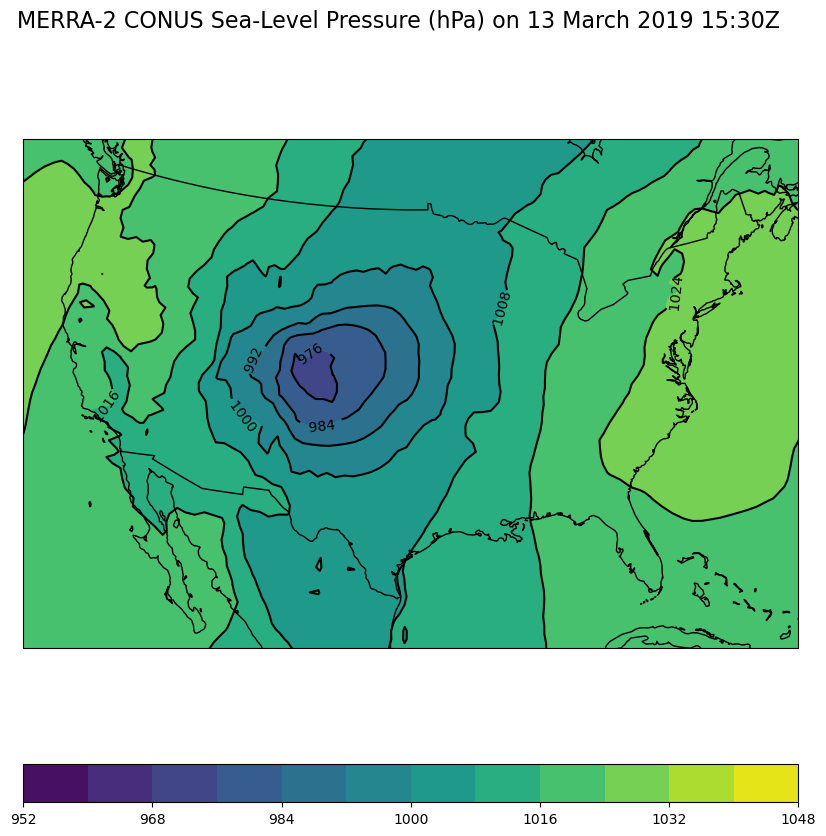

In [7]:
plt.rcParams['figure.figsize'] = 10,10

# Set up figure
fig = plt.figure()

ax = fig.add_subplot(111, projection=ccrs.LambertConformal())
ax.set_extent([-121, -72, 23, 51], crs=ccrs.PlateCarree()) # CONUS extent
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS)

# Set up filled and line contours
filled_c = ax.contourf(ds.lon, ds.lat, slp, levels=10, 
                       transform=ccrs.PlateCarree())
line_c = ax.contour(ds.lon, ds.lat, slp, levels=10,
                        colors=['black'],
                        transform=ccrs.PlateCarree())

# Set up labelling for contours
ax.clabel(line_c,  
    colors=['black'],
    manual=False,  
    inline=True,  
    fmt=' {:.0f} '.format,  
    )

# Set up colorbar and figure title
fig.colorbar(filled_c, orientation='horizontal')
fig.suptitle('MERRA-2 CONUS Sea-Level Pressure (hPa) on 13 March 2019 15:30Z', fontsize=16)

plt.show()